# Install libraries

In [1]:
pip install numpy scipy rasterio pandas matplotlib pyproj geopandas bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [2]:
# Standard library imports
import time

# Related third-party imports
import matplotlib.pyplot as plt
import numpy as np
import config # Importing the main config.py file containing PyFlood parameters
import pandas as pd
import rasterio
import geopandas as gpd
import config
import importlib
from rasterio.transform import xy
from rasterio.transform import from_origin
from scipy.io import loadmat, savemat
from scipy.interpolate import griddata
from scipy.ndimage import zoom
from scipy.spatial.distance import cdist
from scipy.linalg import inv
from scipy.ndimage import binary_erosion, binary_dilation
from shapely.geometry import Point
from skimage import measure, morphology, util
from skimage.measure import label, find_contours
from skimage.transform import resize
from skimage.feature import canny
from sklearn.metrics import mean_squared_error
from math import sqrt
from bayes_opt import BayesianOptimization

importlib.reload(config)

<module 'config' from 'C:\\Users\\as229858\\Documents\\PyFlood\\config.py'>

# Required Functions for PyFlood Pre-Calibration Coastal Flood Map

In [3]:
def plot_data(lon, lat, data, title):
    """
    Plots geographical data on a 2D map using longitude and latitude as axes.

    This function creates a color-mesh plot of the specified data over a geographical
    area defined by longitude and latitude coordinates. It's suitable for visualizing
    spatial data such as flood depth, elevation, and other relevant metrics in coastal engineering.

    Parameters
    ----------
    lon : 2D array-like
        Longitude coordinates of the data points.
    lat : 2D array-like
        Latitude coordinates of the data points.
    data : 2D array-like
        The data to be plotted. Must match the dimensions of lon and lat.
    title : str
        Title of the plot, indicating the type of data being visualized.

    Returns
    -------
    None
        Displays the plot.

    Examples
    --------
    >>> plot_data(lon, lat, FloodDepth, 'Flood Depth')
    >>> plot_data(lon, lat, FloodDepthAndSea, 'Flood Depth and Sea')
    >>> plot_data(lon, lat, z, 'Elevation (z)')
    """
    # Initialize the plot with specified figure size
    plt.figure(figsize=(10, 8))
    
    # Create a color-mesh plot of the data
    plt.pcolormesh(lon, lat, data, shading='auto')
    
    # Add a color scale to the plot for reference
    plt.colorbar()
    
    # Set the plot title and labels for axes
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Display the plot
    plt.show()

In [4]:
def bwboundaries_sfm(binary_image, connectivity=8):
    """
    Identifies the boundaries of objects and holes in a binary image.

    This function labels the regions in a binary image representing objects
    and holes based on the specified connectivity. It uses the labeling
    algorithm from the scikit-image library to find connected components.

    Parameters
    ----------
    binary_image : 2D array-like
        A binary image where nonzero (True) pixels belong to objects and
        0 (False) pixels to the background.
    connectivity : int, optional
        The connectivity criterion (4 or 8) used for labeling. 8-connectivity
        means that diagonal pixels are considered neighbors, while 4-connectivity
        means only horizontal and vertical neighbors are considered. Default is 8.

    Returns
    -------
    L_SFM : dict of {'objects': 2D numpy.ndarray, 'holes': 2D numpy.ndarray}
        A dictionary containing labeled images of objects and holes. Each unique
        number in the arrays represents a distinct object or hole, with the
        background labeled as 0.

    Raises
    ------
    ValueError
        If `connectivity` is not 4 or 8.

    Examples
    --------
    >>> binary_image = np.array([[0, 0, 1, 1, 0],
    ...                          [0, 1, 1, 0, 0],
    ...                          [0, 0, 0, 0, 0],
    ...                          [0, 1, 1, 1, 0],
    ...                          [0, 0, 0, 0, 0]], dtype=bool)
    >>> boundaries = bwboundaries_sfm(binary_image, connectivity=8)
    >>> print(boundaries['objects'])
    >>> print(boundaries['holes'])
    """
    
    # Start the timer
    start_time = time.time()
    
    # Ensure the input image is binary; convert if necessary
    if not np.issubdtype(binary_image.dtype, np.bool_):
        binary_image = binary_image != 0
    
    # Map the specified connectivity to scikit-image's convention
    if connectivity == 8:
        skimage_connectivity = 2
    elif connectivity == 4:
        skimage_connectivity = 1
    else:
        # Validate the specified connectivity
        raise ValueError("Connectivity must be 4 or 8.")
   
    # Label objects in the binary image
    labeled_image = measure.label(binary_image, connectivity=skimage_connectivity)
    
    # Invert the image to label holes, adjusting connectivity accordingly
    inverted_image = util.invert(binary_image)
    hole_connectivity = 1 if skimage_connectivity == 2 else 2
    labeled_holes = measure.label(inverted_image, connectivity=hole_connectivity)
    
    # Optionally, if you need contours, you can find them here
    # It is commented because it causes a considerable delay in the runtime
    # contours = [measure.find_contours(labeled_image == i, level=0.5) for i in np.unique(labeled_image)[1:]]
    
    # Return the labeled objects and holes as a dictionary
    L_SFM = {'objects': labeled_image, 'holes': labeled_holes}
    
    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"bwboundaries_sfm execution time: {duration} seconds")
    
    return L_SFM

In [5]:
def calc_distance_matrix(land, lon_matrix, lat_matrix):
    """
    Calculates the distances from a given land point to each point in a grid defined by longitude and latitude matrices.

    This function uses the Haversine formula to compute the distance between the land point and each point in the grid,
    considering the Earth's curvature. It returns the minimum distance found and the position of the closest point in the grid.

    Parameters
    ----------
    land : tuple or list
        A pair (longitude, latitude) representing the specific land point from which distances are calculated.
    lon_matrix : 2D numpy.ndarray
        The longitude values of the grid points.
    lat_matrix : 2D numpy.ndarray
        The latitude values of the grid points.

    Returns
    -------
    mindist : float
        The minimum distance (in meters) from the land point to the closest grid point.
    minpos : tuple
        The position (row, column) in the grid of the closest point to the land point.

    Examples
    --------
    >>> land = (-95.3698, 29.7604)  # Longitude and latitude of a point
    >>> lon_matrix = np.array([[-95.3697, -95.3696], [-95.3695, -95.3694]])
    >>> lat_matrix = np.array([[29.7603, 29.7602], [29.7601, 29.7600]])
    >>> mindist, minpos = calc_distance_matrix(land, lon_matrix, lat_matrix)
    >>> print(f"Minimum distance: {mindist} meters, Position: {minpos}")
    """
    # Start the timer
    start_time = time.time()
    
    # Earth radius in kilometers
    Rt = 6371
    
    # Convert latitude to radians for distance calculation
    r_lat = (2 * np.pi * Rt) / 360

    # Calculate the longitude radius for each grid point considering Earth's curvature
    r_lon_matrix = 2 * np.pi * Rt * np.cos(np.radians((lat_matrix + land[1]) / 2)) / 360
    
    # Compute distances using the Haversine formula adapted for matrix operations
    dists_matrix = np.sqrt(((lon_matrix - land[0]) * r_lon_matrix)**2 + ((lat_matrix - land[1]) * r_lat)**2)
    
    # Identify the minimum distance and its position within the matrix
    mindist = np.min(dists_matrix)
    minpos = np.unravel_index(np.argmin(dists_matrix), dists_matrix.shape)

    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"calc_distance_matrix execution time: {duration} seconds")
    
    # Convert the minimum distance from kilometers to meters and return it with the position
    return mindist * 1000, minpos

In [6]:
def static_flooding(lon, lat, z, wl, wb):
    """
    Simulates flooding based on digital elevation model (DEM) data, water level, and a reference sea point.

    This function creates a simplified static flooding model by subtracting the water level from the
    DEM data to identify flooded areas. It uses binary image processing to distinguish between water and land,
    identifies connected components as water bodies, and calculates the depth of flooding.

    Parameters
    ----------
    lon : 2D numpy.ndarray
        Longitude coordinates corresponding to each point in the DEM data.
    lat : 2D numpy.ndarray
        Latitude coordinates corresponding to each point in the DEM data.
    z : 2D numpy.ndarray
        Elevation data from the DEM, where each value represents the elevation at the corresponding point.
    wl : float
        The water level used to simulate flooding. All elevations below this value are considered flooded.
    wb : tuple or list
        A pair (longitude, latitude) representing a specific point known to be within the main water body (e.g., the sea).

    Returns
    -------
    SF : dict
        A dictionary with two keys:
        'FloodDepth' : 2D numpy.ndarray
            Indicates the depth of flooding at each point where new land is inundated.
        'FloodDepthAndSea' : 2D numpy.ndarray
            Includes both the depth of flooding over land and the original water body.

    Examples
    --------
    >>> lon = np.array([[...], [...]])
    >>> lat = np.array([[...], [...]])
    >>> z = np.array([[...], [...]])
    >>> wl = 1.5
    >>> wb = (-95.3698, 29.7604)
    >>> SF = static_flooding(lon, lat, z, wl, wb)
    >>> print(SF['FloodDepth'])
    >>> print(SF['FloodDepthAndSea'])
    """
    # Start the timer
    start_time = time.time()
    
    # Adjust the topography based on the water level to identify potential flooding areas
    zF = z - wl

    # Convert to a binary image indicating water (1) and land (0)
    zBW = np.where(zF > 0, np.nan, 1)  # Mark potential water areas
    zBW = np.where(np.isnan(zBW), 0, zBW)  # Ensure land is marked as 0

    # Use the custom function to identify the connected components representing bodies of water and land
    Lc = bwboundaries_sfm(zBW)

    # Determine which of the identified bodies of water is connected to the sea
    mindist, minpos = calc_distance_matrix(wb, lon, lat)
    Lwb1 = Lc['objects'][minpos]
    Lwb2 = Lc['holes'][minpos]

    # Mark the main water body and any connected flooded areas
    Lp = np.zeros_like(z)
    Lp[Lc['objects'] == Lwb1] = 1
    holes = np.zeros_like(z)
    holes[Lc['holes'] == Lwb2] = 1
    L = Lp + holes  # Combine to get the final flooded areas

    # Calculate the depth of flooding in these areas
    fpos = np.where(L == 2)
    FloodDepthAndSea = np.full_like(z, np.nan)
    FloodDepthAndSea[fpos] = zF[fpos]

    # Separate new flooded areas from the existing water body
    FloodDepth = np.full_like(z, np.nan)
    FloodDepth[fpos] = FloodDepthAndSea[fpos]
    FloodDepth[z <= 0] = np.nan  # Exclude existing water bodies

    # Compile the results into a dictionary
    SF = {
        'FloodDepth': FloodDepth,
        'FloodDepthAndSea': FloodDepthAndSea,
    }
    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"static_flooding execution time: {duration} seconds")

    return SF

In [7]:
def red_fac_grid_FOL(lon, lat, z, rf, L):
    """
    Calculates a grid of spatially varying reduction factors based on observed reduction factors and a correlation length.

    This function uses a Gaussian function to spatially interpolate the observed reduction factors across a grid defined
    by the longitude, latitude, and elevation data. The correlation length (L) controls the spatial influence of each
    observation.

    Parameters
    ----------
    lon : 2D numpy.ndarray
        Longitude values of the grid points.
    lat : 2D numpy.ndarray
        Latitude values of the grid points.
    z : 2D numpy.ndarray
        Elevation values of the grid points.
    rf : 2D numpy.ndarray
        Observed reduction factors with their corresponding longitude and latitude.
        Each row should be [longitude, latitude, reduction factor].
    L : float
        Correlation length determining the spatial influence of the observed reduction factors.

    Returns
    -------
    rfgrid : 2D numpy.ndarray
        The spatially varying reduction factor grid, with the same shape as the elevation data (z).

    Examples
    --------
    >>> lon = np.array([[...], [...]])
    >>> lat = np.array([[...], [...]])
    >>> z = np.array([[...], [...]])
    >>> rf = np.array([[lon1, lat1, rf1], [lon2, lat2, rf2], ...])
    >>> L = 10.0  # Example correlation length
    >>> rfgrid = red_fac_grid_FOL(lon, lat, z, rf, L)
    >>> print(rfgrid)
    """
    
    # Constants
    g = 0.01  # gamma, representing observational error
    Rt = 6371  # Earth radius in kilometers
    
    # Prepare the reduction factor data by removing any NaN values
    rf = rf[~np.isnan(rf[:, 2])]
    
    # Calculate background and anomalies in the reduction factors
    Vback = np.mean(rf[:, 2])  # Background value of the reduction factors
    Vo = rf - Vback  # Anomalies from the background

    # Prepare the land matrix using the DEM data
    land = np.column_stack((lon.flatten(), lat.flatten(), z.flatten()))
    
    # Calculate the Euclidean distances between land points and observed reduction factor points
    Va = land[:, :2]  # Coordinates of the land points
    DE = cdist(Va, Vo[:, :2], metric='euclidean')  # Distances matrix

    # Weight matrix for land points vs observed points using Gaussian function
    WD = np.exp(-np.square(DE) / (2 * np.square(L)))
    
    # Calculate the distances and weight matrix among observed points
    TE = cdist(Vo[:, :2], Vo[:, :2], metric='euclidean')
    WT = np.exp(-np.square(TE) / (2 * np.square(L)))

    # Gamma matrix to account for observational error
    gamma = g * np.eye(WT.shape[0])
    TTT = WT + gamma  # Combine observational weights with the gamma matrix
    TTT_inv = inv(TTT)  # Invert the combined matrix

    # Normalize the weights and calculate the interpolated reduction factors
    P = np.dot(WD, TTT_inv)
    P[P < 0] = 0  # Ensure no negative weights
    weightsum = np.sum(P, axis=1)
    weightsum[weightsum < 1] = 1
    Pnorm = P / weightsum[:, np.newaxis]  # Normalize the weights

    # Calculate the interpolated reduction factors and reshape back to the grid
    Vinterp = np.dot(Pnorm, Vo[:, 2]) + Vback
    rfgrid = Vinterp.reshape(z.shape)

    return rfgrid

In [8]:
def find_opt_L(SF, rf_lonlat):
    """
    Determines the optimal correlation length (L) for spatially varying reduction factors.

    This function iterates over a range of possible L values, calculating a spatially varying reduction factor grid for each.
    It then evaluates each L based on the difference between the interpolated reduction factors and the observed ones,
    choosing the L that minimizes this difference while considering the standard deviation across the grid as a measure of spatial variability.

    Parameters
    ----------
    SF : dict
        A dictionary containing the 'lat', 'lon', and 'z' keys representing latitude, longitude, and elevation data, respectively.
    rf_lonlat : numpy.ndarray
        An array of observed reduction factors with their corresponding longitude and latitude.
        Each row should be [longitude, latitude, reduction factor].

    Returns
    -------
    L_opt : float
        The optimal correlation length that minimizes the difference between interpolated and observed reduction factors,
        while considering spatial variability.

    Examples
    --------
    >>> SF = {
    ...     'lat': np.array([[...], [...]]),
    ...     'lon': np.array([[...], [...]]),
    ...     'z': np.array([[...], [...]])
    ... }
    >>> rf_lonlat = np.array([[lon1, lat1, rf1], [lon2, lat2, rf2], ...])
    >>> L_opt = find_opt_L(SF, rf_lonlat)
    >>> print(f"Optimal correlation length: {L_opt}")
    """
    # Start the timer
    start_time = time.time()
    
    # Define a range of L values to test
    L_test = np.arange(0.5, 100.5, 0.5)
    D2 = []  # Mean differences between interpolated and observed reduction factors
    STDs = []  # Standard deviations of interpolated reduction factors across the grid

    # Reduce spatial resolution for computational efficiency
    sires = [500, 500]  # Desired size
    sires[0] = min(SF['z'].shape[0], sires[0])
    sires[1] = min(SF['z'].shape[1], sires[1])

    # Resize the elevation, latitude, and longitude data
    lat2 = zoom(SF['lat'], (sires[0]/SF['lat'].shape[0], sires[1]/SF['lat'].shape[1]))
    lon2 = zoom(SF['lon'], (sires[0]/SF['lon'].shape[0], sires[1]/SF['lon'].shape[1]))
    z2 = zoom(SF['z'], (sires[0]/SF['z'].shape[0], sires[1]/SF['z'].shape[1]))

    # Find positions of observed reduction factors in the resized grid
    P = []
    xy = np.column_stack((lon2.ravel(), lat2.ravel()))
    
    for rf in rf_lonlat:
        distances = np.sqrt((xy[:, 0] - rf[0])**2 + (xy[:, 1] - rf[1])**2)
        P.append(np.argmin(distances))

    # Evaluate each L value
    for L in L_test:
        rfgrid = red_fac_grid_FOL(lon2, lat2, z2, rf_lonlat, L)
        
        # Differences between the interpolated grid and the values at the scalar positions
        D = rfgrid.ravel()[P] - rf_lonlat[:, 2]
        D2.append(np.mean(D))
        STDs.append(np.std(rfgrid))

    # Normalize the metrics to [0, 1] range and compute the ratio
    STDs_n = (STDs - np.min(STDs)) / (np.max(STDs) - np.min(STDs)) if np.max(STDs) != np.min(STDs) else np.zeros_like(STDs)
    D2_n = (D2 - np.min(D2)) / (np.max(D2) - np.min(D2)) if np.max(D2) != np.min(D2) else np.zeros_like(D2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = STDs_n / D2_n
        # Where D2_n is 0, set ratio to 0 to avoid divide by zero issues
        ratio[np.isnan(ratio) | np.isinf(ratio)] = 0
        
    # Determine the optimal L value (Criteria for the optimal value of the interpolation length)
    L_opt_index = np.argmax(ratio)
    L_opt = L_test[L_opt_index]

    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"find_opt_L execution time: {duration} seconds")
    
    return L_opt

In [9]:
def spat_var_wl(lon, lat, z, tg):
    """
    Calculates spatially varying flood water levels based on given water level observations (tide gauges) and an elevation model (z).

    Parameters
    ----------
    lon : 2D numpy.ndarray
        Longitude values of the grid points.
    lat : 2D numpy.ndarray
        Latitude values of the grid points.
    z : 2D numpy.ndarray
        Elevation values of the grid points.
    tg : numpy.ndarray
        Array of water level observations with columns [longitude, latitude, water level].

    Returns
    -------
    fwl : 2D numpy.ndarray
        Interpolated flood water levels at the resolution of the input elevation model.
    L : float
        The optimal correlation length used in the interpolation.

    Examples
    --------
    >>> lon = np.array([[...], [...]])
    >>> lat = np.array([[...], [...]])
    >>> z = np.array([[...], [...]])
    >>> tg = np.array([[lon1, lat1, wl1], [lon2, lat2, wl2], ...])
    >>> fwl, L = spat_var_wl(lon, lat, z, tg)
    >>> print(f"Flood water levels:\n{fwl}")
    >>> print(f"Optimal correlation length: {L}")
    """
    # Start the timer
    start_time = time.time()
    
    # Reduce spatial resolution for computational efficiency
    sires = np.round(np.array(z.shape) / 10).astype(int)
    sires = np.clip(sires, a_min=None, a_max=500)  # Ensuring it does not exceed 500x500
    sires[0] = min(z.shape[0], sires[0])
    sires[1] = min(z.shape[1], sires[1])
    
    # Resize lat, lon, and z
    lat2 = resize(lat, sires, anti_aliasing=True)
    lon2 = resize(lon, sires, anti_aliasing=True)
    z2 = resize(z, sires, anti_aliasing=True)

    # Prepare data structure for find_opt_L function
    SF = {'lon': lon2, 'lat': lat2, 'z': z2}

    # Determine the optimal correlation length (L)
    L = find_opt_L(SF, tg)

    # Parameters for interpolation
    g = 0.01  # Observation error coefficient
    Rt = 6371  # Earth radius in km
    r_lat = (2 * np.pi * Rt) / 360  # Convert degrees to radians for latitude calculations

    # Remove NaN values from tg data
    tg = tg[~np.isnan(tg[:, 2])]

    # Calculate distances and construct weight matrices
    land = np.column_stack((lon2.flatten(), lat2.flatten()))
    Vback = np.min(tg[:, 2])  # Background water level
    Vo = np.hstack((tg[:, :2], (tg[:, 2] - Vback).reshape(-1, 1)))  # Observations adjusted for background
    DE = cdist(land, Vo[:, :2], metric='euclidean')  # Distances from land points to observation points
    WD = np.exp(-DE**2 / (2 * L**2))  # Weight matrix for distances

    TE = cdist(Vo[:, :2], Vo[:, :2], metric='euclidean')  # Distances among observation points
    WT = np.exp(-TE**2 / (2 * L**2))  # Weight matrix among observations

    # Gamma matrix for observation errors and normalization
    gamma = g * np.eye(WT.shape[0])
    TTT = WT + gamma
    P = WD.dot(inv(TTT))
    P[P < 0] = 0  # Ensure non-negative weights
    weightsum = np.maximum(P.sum(axis=1), 1)
    Pnorm = P / weightsum[:, None]  # Normalize weights

    # Interpolate values back to grid and upsample to original resolution
    Vinterp = Pnorm.dot(Vo[:, 2]) + Vback
    fwl_low_res = Vinterp.reshape(sires)
    # Upsample fwl to original resolution
    fwl = griddata((lon2.flatten(), lat2.flatten()), fwl_low_res.flatten(), (lon, lat), method='cubic')

    # Replace NaN values with nearest non-NaN values
    fwl = pd.DataFrame(fwl).fillna(method='bfill', axis=0).fillna(method='ffill', axis=0).values
    fwl = pd.DataFrame(fwl).fillna(method='bfill', axis=1).fillna(method='ffill', axis=1).values

    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"spat_var_wl execution time: {duration} seconds")
    
    return fwl, L

In [10]:
def PyFlood_StaticFlooding(lon, lat, z, wl, wb):
    """
    Simulates flooding over a given topography using either spatially varying
    or uniform flood water levels.

    Parameters
    ----------
    lon : 2D numpy.ndarray
        Array of longitude coordinates.
    lat : 2D numpy.ndarray
        Array of latitude coordinates.
    z : 2D numpy.ndarray
        Array of elevation data.
    wl : numpy.ndarray or float
        Flood water levels. If spatially varying, wl should be an array with
        columns [longitude, latitude, water level]. If uniform, wl can be a scalar
        value or an array with a single row [lon, lat, water level].
    wb : tuple or list
        Coordinates [longitude, latitude] indicating a point on the sea or main water body.

    Returns
    -------
    SF : dict
        A dictionary containing the results of the flood simulation, including flood depth.
    fwl : numpy.ndarray or float
        The flood water level used in the simulation. It will match the input wl format.
    L : float or None
        The optimal correlation length used for spatially varying water level calculations,
        or None if the flood water level is uniform.

    Examples
    --------
    >>> lon = np.array([[...], [...]])
    >>> lat = np.array([[...], [...]])
    >>> z = np.array([[...], [...]])
    >>> wl = np.array([[lon1, lat1, wl1], [lon2, lat2, wl2], ...])
    >>> wb = (-95.3698, 29.7604)
    >>> SF, fwl, L = PyFlood_StaticFlooding(lon, lat, z, wl, wb)
    >>> print(SF['FloodDepth'])
    >>> print(fwl)
    >>> print(L)
    """
    start_time = time.time()
    
    # Determine if spatially varying flood water levels are being used based on the shape of wl
    if np.array(wl).shape[0] > 1:
        print('Calculating spatially varying water level...')
        # Calculate spatially varying flood water levels
        fwl, L = spat_var_wl(lon, lat, z, wl)
    elif np.array(wl).shape[0] == 1:
        print('Using uniform flood water level...')
        # For uniform flood water level, use the input value directly
        fwl = wl if np.isscalar(wl) else wl[-1]
        L = None  # Correlation length is not applicable for uniform water levels

    print('Applying static method to simulate flooding...')
    # Simulate flooding using the specified flood water levels
    SF = static_flooding(lon, lat, z, fwl, wb)

    # Record and print the execution time
    end_time = time.time()
    print(f"PyFlood_StaticFlooding execution time: {end_time - start_time} seconds")
    
    return SF, fwl, L

In [11]:
def calc_distance_to_coast(lon_flat, lat_flat, coastline):
    """
    Calculate the distance of each point in the flattened lon/lat arrays to the nearest coastline point.
    
    Parameters
    ----------
    lon_flat : ndarray
        Flattened array of longitude values.
    lat_flat : ndarray
        Flattened array of latitude values.
    coastline : ndarray
        Array of coastline points where each row is [longitude, latitude, elevation].
        
    Returns
    -------
    min_dists : ndarray
        Array of distances from each lon/lat point to the nearest coastline point in meters.

    Examples
    --------
    >>> lon_flat = np.array([...])
    >>> lat_flat = np.array([...])
    >>> coastline = np.array([[lon1, lat1, elev1], [lon2, lat2, elev2], ...])
    >>> distances = calc_distance_to_coast(lon_flat, lat_flat, coastline)
    >>> print(distances)
    """
    # Start the timer
    start_time = time.time()
    
    Rt = 6371  # Earth radius in km
    r_lat = (2 * np.pi * Rt) / 360
    
    # Initialize an array to store the minimum distances for each point
    min_dists = np.full(lon_flat.shape, np.inf)
    
    # Compute distances from each grid point to each coastline point and update min_dists
    for coast_point in coastline:
        r_lon = 2 * np.pi * Rt * np.cos(np.radians((lat_flat + coast_point[1]) / 2)) / 360
        dists = np.sqrt(((lon_flat - coast_point[0]) * r_lon) ** 2 + ((lat_flat - coast_point[1]) * r_lat) ** 2)
        min_dists = np.minimum(min_dists, dists)
    
    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"calc_distance_to_coast execution time: {duration} seconds")
    
    return min_dists * 1000  # Convert to meters and return

In [12]:
def create_raster_from_dem(lon, lat, z, output_filename):
    """
    Generates a raster image from DEM data and saves it as a GeoTIFF file.

    Parameters
    ----------
    lon : numpy.ndarray
        A 2D array containing the longitude coordinates that define the regular grid of the DEM.
    lat : numpy.ndarray
        A 2D array containing the latitude coordinates that define the regular grid of the DEM.
    z : numpy.ndarray
        A 2D array containing the elevation data of the DEM.
    output_filename : str
        The path and filename for the output GeoTIFF raster file.

    Returns
    -------
    None

    This function assumes that lon and lat are 2D arrays that define a regular grid,
    and that z contains the corresponding elevation data. It calculates the spatial extent,
    cell size, and creates a raster using the rasterio library, applying a transformation to
    fit the GeoTIFF specifications.

    Examples
    --------
    >>> lon = np.array([[...], [...]])
    >>> lat = np.array([[...], [...]])
    >>> z = np.array([[...], [...]])
    >>> output_filename = "output.tif"
    >>> create_raster_from_dem(lon, lat, z, output_filename)
    """
    
    # Start the timer
    start_time = time.time()
    
    # Determine the spatial extent of the raster based on the minimum and maximum coordinates
    xmin, xmax = np.min(lon), np.max(lon)
    ymin, ymax = np.min(lat), np.max(lat)
    
    # Calculate the cell size assuming regular spacing in both longitude and latitude directions
    cell_size_lon = np.abs(lon[0, 1] - lon[0, 0])
    cell_size_lat = np.abs(lat[1, 0] - lat[0, 0])
    
    # Adjust ymin and ymax for rasterio's origin reference (upper left corner)
    ymin, ymax = ymax, ymin
    
    # Create a transformation object for GeoTIFF metadata
    transform = from_origin(xmin, ymin, cell_size_lon, cell_size_lat)
    
    # Set the raster dimensions to match the DEM data size
    height, width = z.shape
    
    # Use rasterio to write the DEM data to a GeoTIFF file
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=str(z.dtype),
        crs=config.crs_to,
        transform=transform,
    ) as dst:
        dst.write(z, 1)  # Write the elevation data to the first band of the raster

    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"create_raster_from_dem execution time: {duration} seconds")

In [13]:
import numpy as np
from scipy.interpolate import griddata
from skimage.transform import resize
import time

def red_fac_appl(lon, lat, z, wb, FloodDepth, rfgrid, prevcalc=None):
    """
    Applies a reduction factor to adjust flood depth values based on distance to the coastline.
    This can refine flood mapping by considering geographical features and elevation.

    Parameters
    ----------
    lon : numpy.ndarray
        2D array of longitude values.
    lat : numpy.ndarray
        2D array of latitude values.
    z : numpy.ndarray
        2D array of elevation data.
    wb : tuple
        Coordinates (longitude, latitude) of a known water body point.
    FloodDepth : numpy.ndarray
        2D array of flood depth values.
    rfgrid : numpy.ndarray
        2D array of reduction factors corresponding to each grid point.
    prevcalc : dict, optional
        Dictionary containing previously calculated 'coastline' and 'distmat_int' to avoid recalculation. Default is None.

    Returns
    -------
    SF_red : dict
        Dictionary containing adjusted flood depth values and other relevant outputs.

    Examples
    --------
    >>> lon = np.array([[...], [...]])
    >>> lat = np.array([[...], [...]])
    >>> z = np.array([[...], [...]])
    >>> wb = (-95.3698, 29.7604)
    >>> FloodDepth = np.array([[...], [...]])
    >>> rfgrid = np.array([[...], [...]])
    >>> SF_red = red_fac_appl(lon, lat, z, wb, FloodDepth, rfgrid)
    >>> print(SF_red['FloodDepthRF'])
    """
    # Start the timer
    start_time = time.time()
    
    if prevcalc is None:
        # 1. Reduce spatial resolution
        res = 50
        rres, cres = np.round(np.array(z.shape) / res).astype(int)

        lat2 = resize(lat, (rres, cres), anti_aliasing=True)
        lon2 = resize(lon, (rres, cres), anti_aliasing=True)
        z2 = resize(z, (rres, cres), anti_aliasing=True)

        # 2. Find coastline using the initial spatial resolution
        coastline, fBW = find_coastline(lon, lat, z, wb)

        # 3. Calculate distances from every point to the coast using DEM
        # Assuming coastline is correctly computed and is an array of points
        coastline_points = coastline[:, :2]  # Extracting just the lon/lat from coastline

        # Now, call the function with the flattened lon/lat arrays and the coastline points
        MinDists = calc_distance_to_coast(lon2.flatten(), lat2.flatten(), coastline_points)
        distmat = MinDists.reshape(z2.shape)  # Reshape if necessary for your use case

        # 4. Transfer distances to the original resolution
        distmat_int = griddata((lon2.flatten(), lat2.flatten()), distmat.flatten(), (lon, lat), method='cubic')
    else:
        coastline = prevcalc['coastline']
        distmat_int = prevcalc['distmat_int']

    # 5. Applying reduction factor
    wl_depth_red = FloodDepth + (rfgrid * distmat_int)
    wl_depth_red[wl_depth_red > 0] = np.nan

    # 6. Correction: remove flooded areas not connected to the main water body
    z_flood = z.copy()
    z_flood[~np.isnan(wl_depth_red)] = wl_depth_red[~np.isnan(wl_depth_red)]
    SF = static_flooding(lon, lat, z_flood, 0, wb)

    FloodDepthRF = SF['FloodDepthAndSea'].copy()
    FloodDepthRF[z <= 0] = np.nan

    # Prepare output
    FloodDepthVecRF = np.column_stack((lon.flatten(), lat.flatten(), FloodDepthRF.flatten()))
    FloodDepthVecRF = FloodDepthVecRF[~np.isnan(FloodDepthVecRF[:, 2])]

    SF_red = {
        'FloodDepthAndSea': SF['FloodDepthAndSea'],
        'FloodDepthVecRF': FloodDepthVecRF,
        'FloodDepthRF': FloodDepthRF,
        'prevcalc': {
            'distmat_int': distmat_int,
            'coastline': coastline
        }
    }

    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"red_fac_appl execution time: {duration} seconds")
    
    return SF_red


In [14]:
def find_coastline(lon, lat, z, wb):
    # Start the timer
    start_time = time.time()
    
    # 1. Identify sea body under present day conditions
    # Black and white bathymetry: water as 1, land as 0
    zBW = np.where(z > 0, np.nan, 1)  # Water
    zBW = np.where(np.isnan(zBW), 0, zBW)  # Land
    
    Lc = bwboundaries_sfm(zBW)
    
    # Find the polygon with the sea boundary (This requires calc_distance function in Python)
    mindist, sea_bound = calc_distance_matrix(wb, lon, lat)

    
    Lwb1 = Lc['objects'][sea_bound]
    Lwb2 = Lc['holes'][sea_bound]

    # Create matrices for polygons and holes
    sea = np.zeros_like(z)
    sea[Lc['objects'] == Lwb1] = 1

    holes = np.zeros_like(z)
    holes[Lc['holes'] == Lwb2] = 0
    
    sea[holes == 1] = 0
    
    # 2. Define coastline using edge detection on the binary sea mask
    coastline_mask = canny(sea)
    fBW = np.argwhere(coastline_mask)
    
    coastline = np.column_stack((lon.flatten(), lat.flatten(), z.flatten()))[coastline_mask.flatten()]
    
    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"find_coastline execution time: {duration} seconds")
    return coastline, fBW

In [15]:
def plot_coastline(coastline):
    """
    Plots coastline points with their elevations.

    Parameters
    ----------
    coastline : array-like, shape (M, 3)
        The coastline data, where each row is a point (longitude, latitude, elevation).

    Examples
    --------
    >>> coastline = np.array([[lon1, lat1, elev1], [lon2, lat2, elev2], ...])
    >>> plot_coastline(coastline)
    """
    # Splitting the coastline array into longitude, latitude, and elevation components
    x, y, z = coastline[:, 0], coastline[:, 1], coastline[:, 2]
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x, y, c=z, cmap='jet', marker='o', edgecolor='k', s=0.01)
    plt.colorbar(scatter, label='Elevation (m)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Coastline Elevation')
    plt.show()

In [16]:
def load_dem_data(dem_path):
    """
    Load DEM data from a .mat file.

    Parameters
    ----------
    dem_path : str
        Path to the .mat file containing DEM data.

    Returns
    -------
    z : numpy.ndarray
        The elevation data matrix.
    lon : numpy.ndarray
        The longitude coordinates of the DEM data points.
    lat : numpy.ndarray
        The latitude coordinates of the DEM data points.

    Examples
    --------
    >>> z, lon, lat = load_dem_data('DEM.mat')
    >>> print(z.shape)
    """
    # Start the timer
    start_time = time.time()
    
    # Load DEM data from the .mat file
    data = loadmat(dem_path)  # Load the data from the .mat file

    # Extract the elevation (z), longitude (lon), and latitude (lat) arrays from the loaded data
    z = data['z']  # Elevation data, representing the height at each point
    lon = data['lon']  # Longitude coordinates of the DEM data points
    lat = data['lat']  # Latitude coordinates of the DEM data points

    # Determine the dimensions of the elevation matrix to understand the size of the DEM
    rows, columns = z.shape  # 'shape' attribute returns the dimensions of the array

    # Print the dimensions of the DEM to provide an overview of its size
    print("DEM Dimensions:", rows, "rows x", columns, "columns")

    # End the timer and calculate the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"Function execution time: {duration} seconds")
    
    return z, lon, lat

# Example usage
# z, lon, lat = load_dem_data('DEM.mat')

# Pre-Calibration Process

In [18]:
# Load the DEM data from the path specified in config.py
dem_data_path = config.dem_data_path
z, lon, lat = load_dem_data(dem_data_path)

# Print the DEM data path to verify it is correctly loaded
# The path points to the file 'DEM.mat' which contains the Digital Elevation Model data
print("DEM data path:", dem_data_path)


DEM Dimensions: 15250 rows x 14000 columns
Function execution time: 11.616828680038452 seconds
DEM data path: DEM.mat


In [19]:
# Import the configuration file
import config

# Assign water body coordinates from config.py to variable wb
wb = config.wb

# Print the coordinates to verify they are correctly loaded
# The coordinates represent a known water body point (e.g., a point in the sea)
# Format: [longitude, latitude]
print("Water body coordinates (longitude, latitude):", wb)

Water body coordinates (longitude, latitude): [-94.85, 29.45]


In [20]:
# Print the uniform water level to verify
wl_s1 = config.wl_s1
print("Uniform water level:", wl_s1)

Uniform water level: [4.696968]


In [21]:
# Load the uniform water level from config.py
wl_s1 = config.wl_s1

# Print the uniform water level to verify it is correctly loaded
# This is a single value representing the water level uniformly applied across the DEM
print("Uniform water level:", wl_s1)

# Load water levels from multiple monitoring stations from config.py
wl_s2 = config.wl_s2

# Print the water levels to verify they are correctly loaded
# Each row represents a monitoring station with format: [longitude, latitude, water level]
print("Water levels from monitoring stations:")
for station in wl_s2:
    print("Station (longitude, latitude, water level):", station)

Uniform water level: [4.696968]
Water levels from monitoring stations:
Station (longitude, latitude, water level): [-95.117222  29.086111   2.883408]
Station (longitude, latitude, water level): [-95.04      29.355833   3.176016]
Station (longitude, latitude, water level): [-94.944722  29.220833   3.770376]
Station (longitude, latitude, water level): [-95.047778  29.456667   3.21564 ]
Station (longitude, latitude, water level): [-94.877778  29.238056   4.416552]
Station (longitude, latitude, water level): [-94.905278  29.303889   3.834384]
Station (longitude, latitude, water level): [-94.877778  29.238056   4.696968]
Station (longitude, latitude, water level): [-94.7933    29.31       3.206496]
Station (longitude, latitude, water level): [-94.7247    29.3575     2.810256]
Station (longitude, latitude, water level): [-94.9202016   29.44745403   3.898392  ]


In [22]:
# Simulate flooding using either spatially varying or uniform water levels.
# The 'wl_s2' variable represents spatially varying water levels from multiple monitoring stations.
# The 'wl_s1' variable represents a uniform water level.
# To use uniform water levels, replace 'wl_s2' with 'wl_s1' in the function call below.

# Example with spatially varying water levels from monitoring stations:
SF2, fwl2, _ = PyFlood_StaticFlooding(lon, lat, z, wl_s2, wb)

# If uniform water levels are desired, use the following line instead:
# SF2, fwl2, _ = PyFlood_StaticFlooding(lon, lat, z, wl_s1, wb)

# Uncomment the following lines to print the results to verify
# print("Flood simulation with spatially varying water levels:")
# print("Flood depth and sea:", SF2['FloodDepthAndSea'])
# print("Flood water levels used:", fwl2)

# Uncomment the following lines to use uniform water levels
# SF2, fwl2, _ = PyFlood_StaticFlooding(lon, lat, z, wl_s1, wb)
# print("Flood simulation with uniform water levels:")
# print("Flood depth and sea:", SF2['FloodDepthAndSea'])
# print("Flood water levels used:", fwl2)

Calculating spatially varying water level...
find_opt_L execution time: 17.718071460723877 seconds


C:\Users\as229858\AppData\Local\Temp\ipykernel_39316\3103035533.py:86: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fwl = pd.DataFrame(fwl).fillna(method='bfill', axis=0).fillna(method='ffill', axis=0).values
C:\Users\as229858\AppData\Local\Temp\ipykernel_39316\3103035533.py:87: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fwl = pd.DataFrame(fwl).fillna(method='bfill', axis=1).fillna(method='ffill', axis=1).values


spat_var_wl execution time: 215.78175973892212 seconds
Applying static method to simulate flooding...
bwboundaries_sfm execution time: 11.260990858078003 seconds
calc_distance_matrix execution time: 13.530534744262695 seconds
static_flooding execution time: 53.41965413093567 seconds
PyFlood_StaticFlooding execution time: 269.67499923706055 seconds


In [23]:
# Identify the coastline from the DEM data by distinguishing between land and water,
# and applying edge detection to the water body. This operation can be time-consuming,
# so we perform it once and store the result for later use.
#
# Parameters:
# - lon : 2D numpy.ndarray, Longitude coordinates of the DEM data points.
# - lat : 2D numpy.ndarray, Latitude coordinates of the DEM data points.
# - z : 2D numpy.ndarray, Elevation data of the DEM.
# - wb : tuple, Coordinates (longitude, latitude) of a known water body point.
#
# Returns:
# - coastline : numpy.ndarray, Array of coastline points where each row is [longitude, latitude, elevation].
# - fBW : numpy.ndarray, Binary image mask indicating the location of the coastline (not needed later).

# Find the coastline using the DEM data and known water body point
coastline, _ = find_coastline(lon, lat, z, wb)  # Discard the second output (fBW) since it is not needed

bwboundaries_sfm execution time: 10.995552062988281 seconds
calc_distance_matrix execution time: 11.70663571357727 seconds
find_coastline execution time: 71.81481742858887 seconds


# Calibration Process

In [24]:
def compute_interpolated_distance_matrix(lon, lat, z, coastline, res=50):
    """
    Computes and interpolates the distance matrix from each point in the DEM to the coastline.

    Parameters
    ----------
    lon : numpy.ndarray
        2D array of longitude coordinates.
    lat : numpy.ndarray
        2D array of latitude coordinates.
    z : numpy.ndarray
        2D array of elevation data.
    coastline : numpy.ndarray
        Array of coastline points where each row is [longitude, latitude, elevation].
    res : int, optional
        Resolution reduction factor for computational efficiency. Default is 50.

    Returns
    -------
    distmat_int : numpy.ndarray
        2D array of distances from each point in the DEM to the coastline, interpolated to the original resolution.

    Examples
    --------
    >>> lon = np.array([[...], [...]])
    >>> lat = np.array([[...], [...]])
    >>> z = np.array([[...], [...]])
    >>> coastline = np.array([[lon1, lat1, elev1], [lon2, lat2, elev2], ...])
    >>> distmat_int = compute_interpolated_distance_matrix(lon, lat, z, coastline)
    >>> print(distmat_int.shape)
    """
    # 1. Reduce spatial resolution
    rres, cres = np.round(np.array(z.shape) / res).astype(int)

    # Resize the latitude, longitude, and elevation matrices to the reduced resolution
    lat2 = resize(lat, (rres, cres), anti_aliasing=True)
    lon2 = resize(lon, (rres, cres), anti_aliasing=True)
    z2 = resize(z, (rres, cres), anti_aliasing=True)

    # 2. Extract the longitude and latitude from the coastline points
    coastline_points = coastline[:, :2]

    # 3. Calculate distances from every point to the coast using DEM
    MinDists = calc_distance_to_coast(lon2.flatten(), lat2.flatten(), coastline_points)
    distmat = MinDists.reshape(z2.shape)

    # 4. Transfer distances to the original resolution
    distmat_int = griddata((lon2.flatten(), lat2.flatten()), distmat.flatten(), (lon, lat), method='cubic')

    return distmat_int

# Example usage
# lon, lat, z, coastline = ...  # Load or define your DEM data and coastline points
# distmat_int = compute_interpolated_distance_matrix(lon, lat, z, coastline)

In [25]:
distmat_int = compute_interpolated_distance_matrix(lon, lat, z, coastline)

calc_distance_to_coast execution time: 642.2167870998383 seconds


In [26]:
def load_land_cover_data(file_path):
    """
    Loads land cover data from a .mat file to use as a land cover class grid.

    Parameters
    ----------
    file_path : str
        The path to the .mat file containing the land cover data.

    Returns
    -------
    land_cover_rf or rf_test: numpy.ndarray
        The land cover class grid is extracted from the loaded data for which the reduction factor will be optimized based on the ranges.

    Examples
    --------
    >>> file_path = 'land_cover.mat'
    >>> land_cover_rf = load_land_cover_data(file_path)
    >>> print(land_cover_rf.shape)
    """
    # Load land cover data from the .mat file
    data = loadmat(file_path)  # Specify the path to your .mat file

    # Extract the land cover class grid from the loaded data
    land_cover_rf = data['land_cover']  # 'land_cover' represents the land cover class grid

    # Retrieve the dimensions of the land cover class grid
    rows, columns = land_cover_rf.shape  # Shape attribute gives the dimensions of the numpy array

    # Print the dimensions of the land cover class grid
    print("Land Cover Class Grid Dimensions:", rows, "rows x", columns, "columns")

    return land_cover_rf

# Example usage
# file_path = 'land_cover.mat'
# land_cover_rf = load_land_cover_data(file_path)

In [27]:
# Load the path to the land cover data from config.py
land_cover_data_path = config.land_cover_data_path

# Load the land cover data using the specified path
# The function load_land_cover_data reads the land cover data from the file
# and processes it for further use in the analysis
rf_test = load_land_cover_data(land_cover_data_path)

# Print the shape of the loaded land cover data to verify it is correctly loaded
# This helps confirm that the data has been loaded and provides insight into its dimensions
print(f"Land Cover Data Loaded from config: shape: {rf_test.shape}")

Land Cover Class Grid Dimensions: 15250 rows x 14000 columns
Land Cover Data Loaded from config: shape: (15250, 14000)


In [28]:
def load_hwm_shapefile(file_path):
    """
    Loads High Water Marks (HWMs) from a shapefile to be used in the calibration process.

    Parameters
    ----------
    file_path : str
        The path to the shapefile containing the HWMs.

    Returns
    -------
    shapefile_gdf : geopandas.GeoDataFrame
        The GeoDataFrame containing the HWMs loaded from the shapefile.

    Examples
    --------
    >>> file_path = 'HWM_IKE_ORG.shp'
    >>> shapefile_gdf = load_hwm_shapefile(file_path)
    >>> print(shapefile_gdf.head())

    Expected Format
    ---------------
    The shapefile should contain at least the following columns:
    - 'geometry': The geometry of the HWM points (longitude, latitude).
    - 'elevation': The elevation of the HWMs in meters.
    - Additional columns can include metadata about the HWMs.

    Example:
    |   geometry  | elevation | ... |
    |-------------|-----------|-----|
    | POINT(lon1, lat1) | elev1     | ... |
    | POINT(lon2, lat2) | elev2     | ... |
    """
    # Load the shapefile
    shapefile_gdf = gpd.read_file(file_path)

    # Print the first few rows of the GeoDataFrame to verify the format
    print("Loaded HWM shapefile:")
    print(shapefile_gdf.head())

    return shapefile_gdf

In [29]:
# Load the path to the high water marks (HWM) shapefile from config.py
hwm_data_path = config.hwm_data_path

# Load the high water marks shapefile using the specified path
# The function load_hwm_shapefile reads the HWM shapefile and converts it into a GeoDataFrame (gdf)
# This GeoDataFrame contains the spatial information and attributes of the high water marks
shapefile_gdf = load_hwm_shapefile(hwm_data_path)

# Print the first few rows of the loaded GeoDataFrame to verify it is correctly loaded
# This helps confirm that the shapefile has been loaded and provides an overview of its contents
print(shapefile_gdf.head())

Loaded HWM shapefile:
         x        y      z                              geometry
0 -95.1115  29.0912  2.957  POINT Z (-95.11150 29.09120 2.95700)
1 -95.1107  29.0931  3.261  POINT Z (-95.11070 29.09310 3.26100)
2 -95.1097  29.0957  3.139  POINT Z (-95.10970 29.09570 3.13900)
3 -95.0585  29.1299  2.408  POINT Z (-95.05850 29.12990 2.40800)
4 -95.0588  29.1315  2.865  POINT Z (-95.05880 29.13150 2.86500)
         x        y      z                              geometry
0 -95.1115  29.0912  2.957  POINT Z (-95.11150 29.09120 2.95700)
1 -95.1107  29.0931  3.261  POINT Z (-95.11070 29.09310 3.26100)
2 -95.1097  29.0957  3.139  POINT Z (-95.10970 29.09570 3.13900)
3 -95.0585  29.1299  2.408  POINT Z (-95.05850 29.12990 2.40800)
4 -95.0588  29.1315  2.865  POINT Z (-95.05880 29.13150 2.86500)


In [30]:
def apply_rf_to_model(lon, lat, z, wb, FloodDepth, distmat_int, rf_vector, rf_test):
    """
    Applies a reduction factor iteratively based on a given reduction factor vector.

    Parameters
    ----------
    lon : numpy.ndarray
        2D array of longitude coordinates.
    lat : numpy.ndarray
        2D array of latitude coordinates.
    z : numpy.ndarray
        2D array of elevation data.
    wb : tuple
        Coordinates (longitude, latitude) of a known water body point.
    FloodDepth : numpy.ndarray
        2D array of flood depth values.
    distmat_int : numpy.ndarray
        2D array of distances from each point in the DEM to the coastline, interpolated to the original resolution.
    rf_vector : dict
        Dictionary mapping land cover values to their corresponding reduction factors.
    rf_test : numpy.ndarray
        2D array representing the land cover class grid.

    Returns
    -------
    FloodDepthRF : numpy.ndarray
        2D array of adjusted flood depth values after applying the reduction factors.

    Examples
    --------
    >>> lon = np.array([[...], [...]])
    >>> lat = np.array([[...], [...]])
    >>> z = np.array([[...], [...]])
    >>> wb = (-95.3698, 29.7604)
    >>> FloodDepth = np.array([[...], [...]])
    >>> distmat_int = np.array([[...], [...]])
    >>> rf_vector = {2: 0.5, 3: 0.7, 4: 0.9}
    >>> rf_test = np.array([[2, 3], [4, 2]])
    >>> FloodDepthRF = apply_rf_to_model(lon, lat, z, wb, FloodDepth, distmat_int, rf_vector, rf_test)
    >>> print(FloodDepthRF)

    """
    # Map land cover values in rf_test to their corresponding reduction factors
    rf_adjusted = np.copy(rf_test)
    for land_cover_value, reduction_factor in rf_vector.items():
        rf_adjusted[rf_test == land_cover_value] = reduction_factor
    
    # Applying reduction factor
    wl_depth_red = FloodDepth + (rf_adjusted * distmat_int)
    wl_depth_red[wl_depth_red > 0] = np.nan

    # Correction: remove flooded areas not connected to the main water body
    z_flood = z.copy()
    z_flood[~np.isnan(wl_depth_red)] = wl_depth_red[~np.isnan(wl_depth_red)]
    SF = static_flooding(lon, lat, z_flood, 0, wb)

    FloodDepthRF = SF['FloodDepthAndSea'].copy()
    FloodDepthRF[z <= 0] = np.nan

    return FloodDepthRF

In [31]:
def objective_function(**rf_values):
    """
    Objective function for Bayesian optimization to calibrate the flood model.

    This function applies the reduction factor vector to the flood model,
    extracts the predicted flood depth values, and calculates the mean squared error (MSE)
    between the predicted and observed flood depths.

    Parameters
    ----------
    rf_values : dict
        Dictionary of reduction factor values, where keys are of the form 'rf_X' and values are the corresponding reduction factors.

    Returns
    -------
    float
        The negative mean squared error (MSE) between the predicted and observed flood depths.

    Examples
    --------
    >>> rf_values = {'rf_2': 0.5, 'rf_3': 0.7, 'rf_4': 0.9}
    >>> score = objective_function_17(**rf_values)
    >>> print(score)

    Notes
    -----
    This function is designed to be used with a Bayesian optimization algorithm to find the optimal reduction factors for the flood model calibration.
    """
    # Convert rf_values keys to integers and values as they are
    rf_vector = {int(k.split('_')[1]): v for k, v in rf_values.items()}

    # Apply the rf_vector to the model to get the predicted flood depth
    FloodDepthRF = apply_rf_to_model(lon, lat, z, wb, SF2['FloodDepth'], distmat_int, rf_vector, rf_test)

    # Function to find the nearest index in the array for a given value
    def find_nearest_index(array, value):
        idx = np.abs(array - value).argmin()
        return idx

    # Function to extract values and indices from FloodDepthRF using shapefile points
    def extract_values_and_indices(lon, lat, FloodDepthRF, shapefile_gdf):
        z_values = []
        indices = []
        for point in shapefile_gdf.geometry:
            col = find_nearest_index(lon[0, :], point.x)
            row = find_nearest_index(lat[:, 0], point.y)
            value = FloodDepthRF[row, col]
            z_values.append(value)
            indices.append((row, col))
        return z_values, indices

    # Function to calculate MSE and return valid indices
    def calculate_mse_and_get_valid_indices(reference_values, comparison_values, indices):
        mask = ~np.isnan(reference_values) & ~np.isnan(comparison_values)
        filtered_ref_values = np.array(reference_values)[mask]
        filtered_comp_values = np.array(comparison_values)[mask]
        mse = mean_squared_error(filtered_ref_values, filtered_comp_values)
        num_points = np.sum(mask)
        print("Number of points considered for MSE:", num_points)  # Display the number of points
        return mse

    # Extracting values and indices from FloodDepthRF
    z_values, indices = extract_values_and_indices(lon, lat, -FloodDepthRF, shapefile_gdf)
    reference_values = shapefile_gdf['z'].tolist()

    # Calculate MSE
    mse = calculate_mse_and_get_valid_indices(reference_values, z_values, indices)

    # Since Bayesian Optimization seeks to maximize the function, return the negative MSE
    return -mse

In [32]:
def define_parameter_bounds(value_mapping_min, value_mapping_max):
    """
    Defines the parameter bounds for Bayesian optimization using given minimum and maximum value mappings.

    Parameters
    ----------
    value_mapping_min : dict
        Dictionary containing the minimum values for each land cover class.
    value_mapping_max : dict
        Dictionary containing the maximum values for each land cover class.

    Returns
    -------
    pbounds : dict
        Dictionary containing the parameter bounds for Bayesian optimization.

    Examples
    --------
    >>> value_mapping_min = {
    ...     2.0: 6e-06,
    ...     3.0: 4e-06,
    ...     4.0: 1.8e-06,
    ...     5.0: 5.4e-07,
    ...     # Add other values...
    ... }
    >>> value_mapping_max = {
    ...     2.0: 0.01,
    ...     3.0: 0.0006,
    ...     4.0: 0.00036,
    ...     5.0: 9e-05,
    ...     # Add other values...
    ... }
    >>> pbounds = define_parameter_bounds(value_mapping_min, value_mapping_max)
    >>> print(pbounds)
    """
    pbounds = {f'rf_{int(k)}': (value_mapping_min[k], value_mapping_max[k]) for k in value_mapping_min.keys()}
    return pbounds

In [33]:
# Load the minimum bounds for land cover class IDs from config.py
min_bound = config.value_mapping_min

# Load the maximum bounds for land cover class IDs from config.py
max_bound = config.value_mapping_max

# Define the parameter bounds for the calibration process
# The function define_parameter_bounds takes the minimum and maximum bounds
# and creates a structure that can be used in the calibration process
# This structure (pbounds) typically includes parameter names and their respective bounds
pbounds = define_parameter_bounds(min_bound, max_bound)

# Print the parameter bounds to verify they are correctly defined
# This helps confirm that the bounds have been loaded and processed correctly
print("Parameter bounds defined for calibration:")
print(pbounds)

Parameter bounds defined for calibration:
{'rf_2': (6e-06, 0.01), 'rf_3': (4e-06, 0.0006), 'rf_4': (1.8e-06, 0.00036), 'rf_5': (5.4e-07, 9e-05), 'rf_6': (0.00016, 0.0004), 'rf_7': (0.000125, 0.0025), 'rf_8': (1.25e-06, 0.00025), 'rf_9': (5e-06, 0.001), 'rf_10': (4e-06, 0.002426), 'rf_11': (0.0002, 0.0005), 'rf_12': (3.5e-06, 0.002413), 'rf_13': (1.5e-06, 0.0005), 'rf_14': (1.25e-06, 0.00025), 'rf_15': (0.00025, 0.00425), 'rf_16': (0.00015, 0.0005), 'rf_17': (1.25e-06, 0.00025), 'rf_18': (2.5e-06, 0.000425), 'rf_19': (1.15e-06, 0.0015), 'rf_20': (1.15e-06, 0.00015), 'rf_21': (0.000125, 0.00025), 'rf_22': (0.000125, 0.00025), 'rf_23': (0.000125, 0.00025)}


In [34]:
# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=1
)

# Run optimization, init_points as initial points and n_iter as number of iterations can be changed
optimizer.maximize(init_points=1, n_iter=5)

# Print the best result
print(optimizer.max)

|   iter    |  target   |   rf_10   |   rf_11   |   rf_12   |   rf_13   |   rf_14   |   rf_15   |   rf_16   |   rf_17   |   rf_18   |   rf_19   |   rf_2    |   rf_20   |   rf_21   |   rf_22   |   rf_23   |   rf_3    |   rf_4    |   rf_5    |   rf_6    |   rf_7    |   rf_8    |   rf_9    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
bwboundaries_sfm execution time: 2.645787239074707 seconds
calc_distance_matrix execution time: 13.2707839012146 seconds
static_flooding execution time: 26.1124746799469 seconds
Number of points considered for MSE: 29
| 1         | -4.214    | 0.001014  | 0.0004161 | 3.776e-06 | 0.0001522 | 3.776e-05 | 0.0006194 | 0.0002152 | 8.721e-05 | 0.0001701 | 0.0008088 | 0.004195  | 0.0001031 | 0.0001506 | 0.0002348 | 0.000128

In [35]:
def format_optimizer_max(optimizer_max):
    """
    Formats the optimizer max results into a dictionary with the same structure as value_mapping_max.

    Parameters
    ----------
    optimizer_max : dict
        The max result from the Bayesian optimizer.

    Returns
    -------
    formatted_max : dict
        Dictionary containing the best parameters with the same structure as value_mapping_max.

    Examples
    --------
    >>> optimizer_max = optimizer.max['params']
    >>> formatted_max = format_optimizer_max(optimizer_max)
    >>> print(formatted_max)
    """
    formatted_max = {int(k.split('_')[1]): v for k, v in optimizer_max.items()}
    return formatted_max

# Example usage after running Bayesian optimization
# optimizer.max contains the result
best_params = optimizer.max['params']
optimized_rf = format_optimizer_max(best_params)
print(optimized_rf)

{10: 0.002426, 11: 0.0002, 12: 0.002413, 13: 0.0005, 14: 0.00025, 15: 0.00425, 16: 0.0005, 17: 0.00025, 18: 2.5e-06, 19: 1.15e-06, 2: 0.01, 20: 1.15e-06, 21: 0.00025, 22: 0.000125, 23: 0.00025, 3: 4e-06, 4: 1.8e-06, 5: 5.4e-07, 6: 0.0004, 7: 0.0025, 8: 1.25e-06, 9: 5e-06}


# Post-Calibration Process

In [36]:
"""
This line applies the optimized reduction factors to obtain the calibrated flood inundation elevation.

Parameters
----------
lon : numpy.ndarray
    2D array of longitude coordinates.
lat : numpy.ndarray
    2D array of latitude coordinates.
z : numpy.ndarray
    2D array of elevation data.
wb : tuple
    Coordinates (longitude, latitude) of a known water body point.
SF2['FloodDepth'] : numpy.ndarray
    2D array of flood depth values.
distmat_int : numpy.ndarray
    2D array of distances from each point in the DEM to the coastline, interpolated to the original resolution.
optimized_rf : dict
    Dictionary mapping land cover values to their corresponding optimized reduction factors.
rf_test : numpy.ndarray
    2D array representing the land cover class grid.

Returns
-------
FloodDepthRF_min_opt_new : numpy.ndarray
    2D array of adjusted flood depth values after applying the optimized reduction factors.
"""
# Apply the optimized reduction factors to obtain the calibrated flood inundation elevation
post_ccfm = apply_rf_to_model(lon, lat, z, wb, SF2['FloodDepth'], distmat_int, optimized_rf, rf_test)

bwboundaries_sfm execution time: 2.898369073867798 seconds
calc_distance_matrix execution time: 12.610236406326294 seconds
static_flooding execution time: 25.697262048721313 seconds


# Generation of Pre-Calibration Coastal Flood Map and Post-Calibration Coastal Flood Map

In [37]:
def filter_flood_depth(FloodDepthRF, threshold):
    """
    Applies a threshold filter to the flood depth values.

    This function sets flood depth values above the given threshold (less negative)
    to NaN, effectively filtering out depths below a certain value.

    Parameters
    ----------
    FloodDepthRF : numpy.ndarray
        2D array of flood depth values.
    threshold : float
        Threshold value for filtering. Values above this threshold (less negative) are set to NaN.

    Returns
    -------
    FloodDepthRF_filtered : numpy.ndarray
        2D array of flood depth values after applying the threshold filter.

    Examples
    --------
    >>> FloodDepthRF_min_opt_new = np.array([[ -1.5, -0.5], [-2.0, -3.0]])
    >>> threshold_value = -1  # Equivalent to 1 meter
    >>> FloodDepthRF_filtered_opt = filter_flood_depth(FloodDepthRF_min_opt_new, threshold_value)
    >>> print(FloodDepthRF_filtered_opt)
    array([[ -1.5,  nan],
           [ -2.0,  -3.0]])
    """
    # Apply threshold filtering, set values above threshold (less negative) to NaN
    FloodDepthRF_filtered = np.where(FloodDepthRF >= threshold, np.nan, FloodDepthRF)
    return FloodDepthRF_filtered

In [38]:
"""
This line creates a raster image from DEM data and saves it as a GeoTIFF file.

Parameters
----------
lon : numpy.ndarray
    A 2D array containing the longitude coordinates that define the regular grid of the DEM.
lat : numpy.ndarray
    A 2D array containing the latitude coordinates that define the regular grid of the DEM.
z : numpy.ndarray
    A 2D array containing the elevation data of the DEM.
output_filename : str
    The path and filename for the output GeoTIFF raster file.
"""

# Assign the threshold value from config.py to be used for generating the Coastal Flood Map
threshold_value = config.threshold_value

# Assign the name of the Pre-Calibration Coastal Flood Map output file after applying the threshold
# This filename is specified in the configuration file
PreCCFM_thr_1m = config.pre_calibration_coastal_flood_map

# Filter the flood depth raster using the specified threshold value
# The function filter_flood_depth applies a filter to the flood depth data, using the threshold value
# This process helps in generating a more accurate representation of the flood extent
pre_ccfm_filtered = filter_flood_depth(SF2['FloodDepth'], threshold_value)

# Create a raster file for the Pre-Calibration Coastal Flood Map using the filtered data
# The function create_raster_from_dem generates a raster file from the DEM data (longitude, latitude, and flood depth)
# The filtered flood depth data is passed as a negative value to ensure proper representation
# The output file is saved with the name specified in PreCCFM_thr_1m
create_raster_from_dem(lon, lat, -pre_ccfm_filtered, PreCCFM_thr_1m)

# Print a message to confirm the process is complete
print(f"Pre-Calibration Coastal Flood Map generated and saved as: {PreCCFM_thr_1m}")

create_raster_from_dem execution time: 4.76820969581604 seconds
Pre-Calibration Coastal Flood Map generated and saved as: PreCCFM_thr_1m.tif


In [39]:
# Assign the name of the Post-Calibration Coastal Flood Map output file after applying the threshold
# This filename is specified in the configuration file
PostCCFM_thr_1m = config.post_calibration_coastal_flood_map

# Filter the post-calibration flood depth raster using the specified threshold value
# The function filter_flood_depth applies a filter to the post-calibration flood depth data using the threshold value
# This process helps in generating a more accurate representation of the flood extent after calibration
post_ccfm_filtered = filter_flood_depth(post_ccfm, threshold_value)

# Create a raster file for the Post-Calibration Coastal Flood Map using the filtered data
# The function create_raster_from_dem generates a raster file from the DEM data (longitude, latitude, and flood depth)
# The filtered flood depth data is passed as a negative value to ensure proper representation
# The output file is saved with the name specified in PostCCFM_thr_1m
create_raster_from_dem(lon, lat, -post_ccfm_filtered, PostCCFM_thr_1m)

# Print a message to confirm the process is complete
print(f"Post-Calibration Coastal Flood Map generated and saved as: {PostCCFM_thr_1m}")

create_raster_from_dem execution time: 1.6271848678588867 seconds
Post-Calibration Coastal Flood Map generated and saved as: PostCCFM_thr_1m.tif


# Difference between high water marks and PreCCFM/PostCCFM

In [40]:
def find_nearest_index(array, value):
    """
    Find the nearest index in the array for a given value.

    Parameters
    ----------
    array : np.ndarray
        Array to search.
    value : float
        Value to find the nearest index for.

    Returns
    -------
    idx : int
        Index of the nearest value in the array.
    """
    idx = np.abs(array - value).argmin()
    return idx

def extract_values_and_indices(lon, lat, FloodDepthRF, shapefile_gdf):
    """
    Extract values and indices from FloodDepthRF using shapefile points.

    Parameters
    ----------
    lon : np.ndarray
        Longitude values of the raster grid.
    lat : np.ndarray
        Latitude values of the raster grid.
    FloodDepthRF : np.ndarray
        Raster data array.
    shapefile_gdf : GeoDataFrame
        GeoDataFrame containing the shapefile data.

    Returns
    -------
    z_values : list
        List of extracted raster values.
    indices : list
        List of indices corresponding to the extracted values.
    coords : list of tuples
        List containing tuples of original and nearest coordinates.
    """
    z_values = []
    indices = []
    coords = []
    for point in shapefile_gdf.geometry:
        col = find_nearest_index(lon[0, :], point.x)
        row = find_nearest_index(lat[:, 0], point.y)
        value = FloodDepthRF[row, col]
        z_values.append(value)
        indices.append((row, col))
        coords.append((point.x, point.y, lon[0, col], lat[row, 0]))
    return z_values, indices, coords

def calculate_rmse(reference_values, comparison_values):
    """
    Calculate the Root Mean Squared Error (RMSE) between reference and comparison values.

    Parameters
    ----------
    reference_values : list
        List of reference z values.
    comparison_values : list
        List of comparison z values.

    Returns
    -------
    mse : float
        Mean Squared Error between the reference and comparison values.
    rmse : float
        Root Mean Squared Error between the reference and comparison values.
    num_points : int
        Number of points considered in the calculation.
    """
    mask = ~np.isnan(reference_values) & ~np.isnan(comparison_values)
    filtered_ref_values = np.array(reference_values)[mask]
    filtered_comp_values = np.array(comparison_values)[mask]
    mse = mean_squared_error(filtered_ref_values, filtered_comp_values)
    rmse = sqrt(mse)
    num_points = np.sum(mask)
    return mse, rmse, num_points

def save_differences_as_shapefile(coords, differences, filename):
    """
    Save the differences along with the coordinates as a new shapefile.

    Parameters
    ----------
    coords : list of tuples
        List containing tuples of original and nearest coordinates.
    differences : list
        List of differences between reference and comparison z values.
    filename : str
        Path to save the new shapefile.

    Returns
    -------
    None
    """
    
    data = {
        'geometry': [Point(coord[0], coord[1]) for coord in coords],
        'difference': differences
    }
    gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")
    gdf.to_file(filename, driver='ESRI Shapefile')
    print(f"Saved differences shapefile to {filename}")

In [41]:
# Example usage with PreCCFM

PreCCFM_shp = config.pre_calibration_coastal_flood_map_shp

shapefile_path = config.hwm_data_path
shapefile_gdf = gpd.read_file(shapefile_path)

z_values, indices, coords = extract_values_and_indices(lon, lat, -SF2['FloodDepth'], shapefile_gdf)
reference_values = shapefile_gdf['z'].tolist()

differences = [comp_val - ref_val for ref_val, comp_val in zip(reference_values, z_values)]

mse, rmse, num_points = calculate_rmse(reference_values, z_values)
print(f"Number of high water marks considered for MSE: {num_points}")
print(f"Calculated MSE: {mse}")
print(f"Calculated RMSE: {rmse}")

# Print the coordinates, z values, and differences for both datasets
print("Index | Original Lon | Original Lat | Nearest Lon | Nearest Lat | Reference z | Comparison z | Difference")
for i, (coord, ref_val, comp_val, diff) in enumerate(zip(coords, reference_values, z_values, differences)):
    orig_lon, orig_lat, near_lon, near_lat = coord
    print(f"{i} | {orig_lon:.6f} | {orig_lat:.6f} | {near_lon:.6f} | {near_lat:.6f} | {ref_val:.3f} | {comp_val:.3f} | {diff:.3f}")

output_shapefile = PreCCFM_shp
save_differences_as_shapefile(coords, differences, output_shapefile)

Number of high water marks considered for MSE: 29
Calculated MSE: 4.014810697605269
Calculated RMSE: 2.0036992532826052
Index | Original Lon | Original Lat | Nearest Lon | Nearest Lat | Reference z | Comparison z | Difference
0 | -95.111500 | 29.091200 | -95.111497 | 29.091188 | 2.957 | 1.640 | -1.317
1 | -95.110700 | 29.093100 | -95.110694 | 29.093102 | 3.261 | 0.547 | -2.714
2 | -95.109700 | 29.095700 | -95.109707 | 29.095694 | 3.139 | 1.424 | -1.715
3 | -95.058500 | 29.129900 | -95.058503 | 29.129892 | 2.408 | 1.713 | -0.695
4 | -95.058800 | 29.131500 | -95.058812 | 29.131497 | 2.865 | 1.975 | -0.890
5 | -95.060200 | 29.132600 | -95.060201 | 29.132608 | 3.261 | 2.011 | -1.250
6 | -95.030000 | 29.147600 | -95.029985 | 29.147608 | 3.139 | 0.808 | -2.331
7 | -95.027900 | 29.149400 | -95.027886 | 29.149398 | 3.109 | 1.283 | -1.826
8 | -95.030300 | 29.149700 | -95.030293 | 29.149707 | 3.109 | 1.001 | -2.108
9 | -94.997700 | 29.173700 | -94.997701 | 29.173688 | 4.298 | 1.504 | -2.794
10 |

In [42]:
# Example usage with PostCCFM

PostCCFM_shp = config.post_calibration_coastal_flood_map_shp

z_values, indices, coords = extract_values_and_indices(lon, lat, -post_ccfm, shapefile_gdf)
reference_values = shapefile_gdf['z'].tolist()

differences = [comp_val - ref_val for ref_val, comp_val in zip(reference_values, z_values)]

mse, rmse, num_points = calculate_rmse(reference_values, z_values)
print(f"Number of high water marks considered for MSE: {num_points}")
print(f"Calculated MSE: {mse}")
print(f"Calculated RMSE: {rmse}")

# Print the coordinates, z values, and differences for both datasets
print("Index | Original Lon | Original Lat | Nearest Lon | Nearest Lat | Reference z | Comparison z | Difference")
for i, (coord, ref_val, comp_val, diff) in enumerate(zip(coords, reference_values, z_values, differences)):
    orig_lon, orig_lat, near_lon, near_lat = coord
    print(f"{i} | {orig_lon:.6f} | {orig_lat:.6f} | {near_lon:.6f} | {near_lat:.6f} | {ref_val:.3f} | {comp_val:.3f} | {diff:.3f}")

output_shapefile = PostCCFM_shp
save_differences_as_shapefile(coords, differences, output_shapefile)

Number of high water marks considered for MSE: 27
Calculated MSE: 3.892436820182898
Calculated RMSE: 1.9729259540547632
Index | Original Lon | Original Lat | Nearest Lon | Nearest Lat | Reference z | Comparison z | Difference
0 | -95.111500 | 29.091200 | -95.111497 | 29.091188 | 2.957 | 1.640 | -1.317
1 | -95.110700 | 29.093100 | -95.110694 | 29.093102 | 3.261 | nan | nan
2 | -95.109700 | 29.095700 | -95.109707 | 29.095694 | 3.139 | 1.423 | -1.716
3 | -95.058500 | 29.129900 | -95.058503 | 29.129892 | 2.408 | 1.713 | -0.695
4 | -95.058800 | 29.131500 | -95.058812 | 29.131497 | 2.865 | 1.975 | -0.890
5 | -95.060200 | 29.132600 | -95.060201 | 29.132608 | 3.261 | 2.011 | -1.250
6 | -95.030000 | 29.147600 | -95.029985 | 29.147608 | 3.139 | nan | nan
7 | -95.027900 | 29.149400 | -95.027886 | 29.149398 | 3.109 | 1.283 | -1.826
8 | -95.030300 | 29.149700 | -95.030293 | 29.149707 | 3.109 | 1.001 | -2.108
9 | -94.997700 | 29.173700 | -94.997701 | 29.173688 | 4.298 | 1.504 | -2.794
10 | -94.96550

# Visualization of Rasters (Optional)

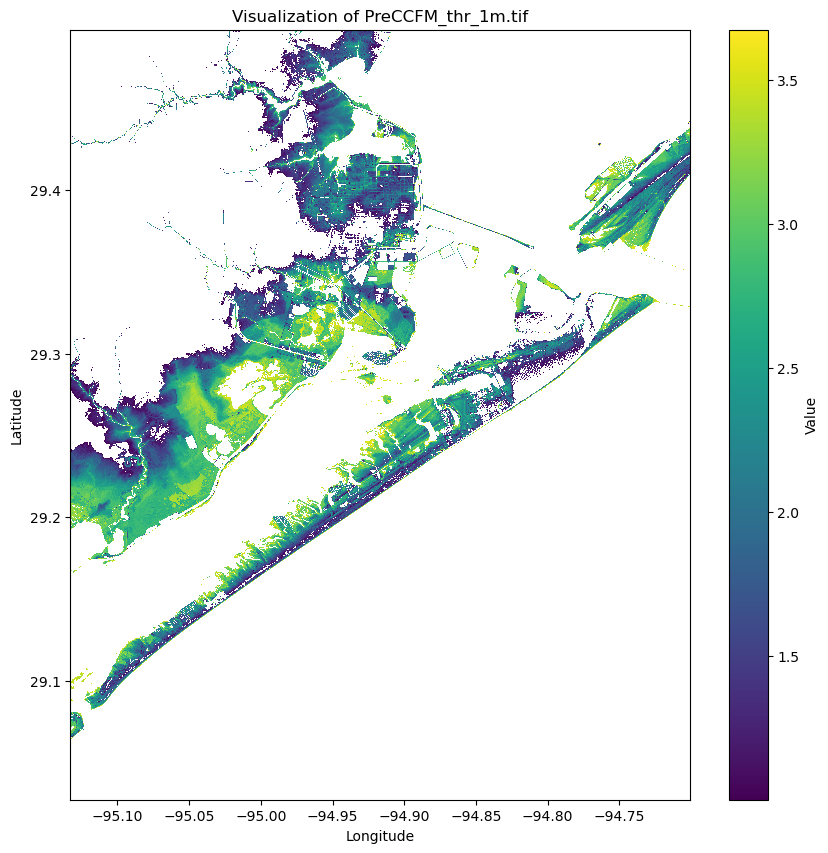

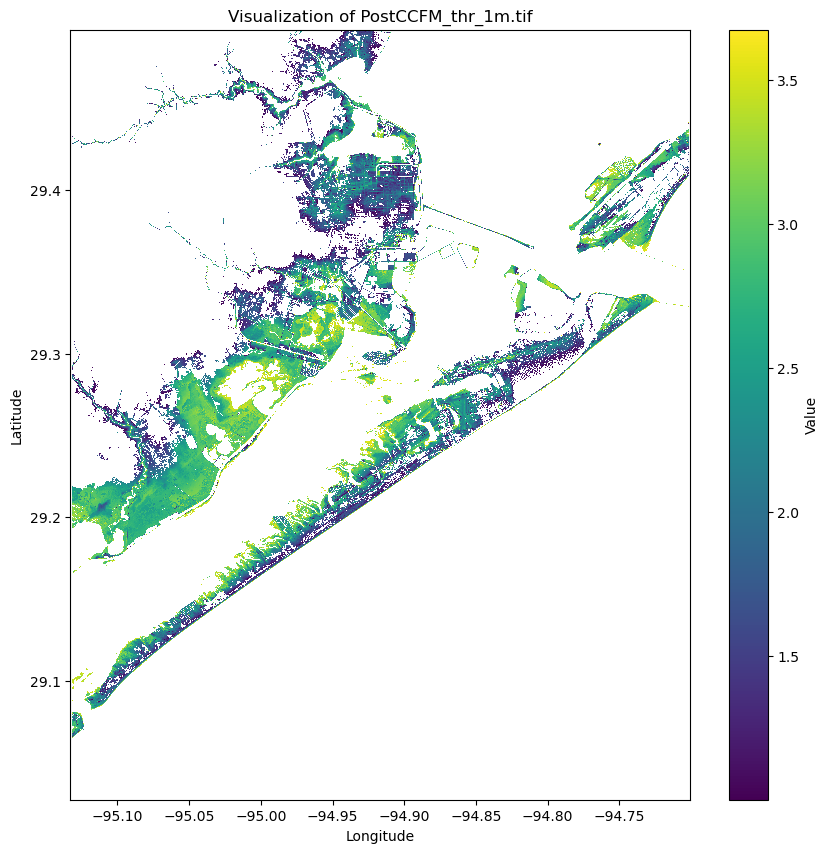

In [43]:
def visualize_raster_tiff(raster_file):
    """
    Visualize a raster TIFF file.

    Parameters
    ----------
    raster_file : str
        Path to the raster TIFF file.

    Returns
    -------
    None

    Examples
    --------
    >>> visualize_raster_tiff('FDR_PreCCFM_thr_1m.tif')
    """
    with rasterio.open(raster_file) as dataset:
        raster_data = dataset.read(1)  # Assuming the data is in the first band
        transform = dataset.transform
        crs = dataset.crs
    
    # Handle NaN values (if necessary)
    raster_data = np.where(raster_data == dataset.nodata, np.nan, raster_data)
    
    # Generate longitude and latitude coordinates
    cols, rows = np.meshgrid(np.arange(raster_data.shape[1]), np.arange(raster_data.shape[0]))
    lon, lat = xy(transform, rows, cols, offset='center')
    
    # Plot the raster data
    plt.figure(figsize=(10, 10))
    plt.pcolormesh(lon, lat, raster_data, shading='auto', cmap='viridis')
    plt.colorbar(label='Value')
    plt.title(f'Visualization of {raster_file}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Example usage
visualize_raster_tiff(PreCCFM_thr_1m)
visualize_raster_tiff(PostCCFM_thr_1m)